# An agent from langchain that can analyze images and text

Made with inspiration from this source code from langchain:

https://python.langchain.com/docs/how_to/document_loader_pdf/#use-of-multimodal-models

In [5]:
# Install the necessary libraries
# uncomment the following lines to install the necessary libraries

%pip install fitz pillow
%pip install --upgrade pymupdf

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 12.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


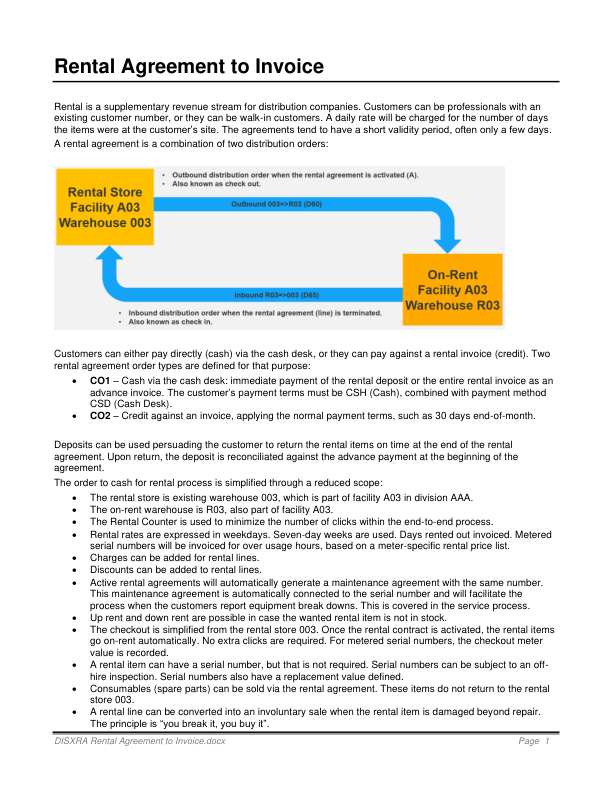

Page 1 analysis:
The document outlines a Rental Agreement process tailored for distribution companies, highlighting key operational procedures and customer interactions. Here's a comprehensive analysis of its content:

### Overview
- **Purpose of Rental**: Rental serves as an additional revenue stream for distribution companies, accommodating both existing customers and walk-in customers. 

### Key Components
1. **Rental Duration and Payment**:
   - Rentals are typically short-term, lasting only a few days.
   - Two payment methods are specified:
     - **CO1**: Cash payment at the cash desk (immediate).
     - **CO2**: Credit payment via invoice, with standard payment terms.

2. **Deposits**: 
   - Customers are incentivized to return rental items on time through a deposit system, which is reconciled upon return.

3. **Order to Cash Process**:
   - The process is simplified within a defined structure:
     - **Warehouses**: 
       - Rental Store: Warehouse 003 (Facility A03).
       

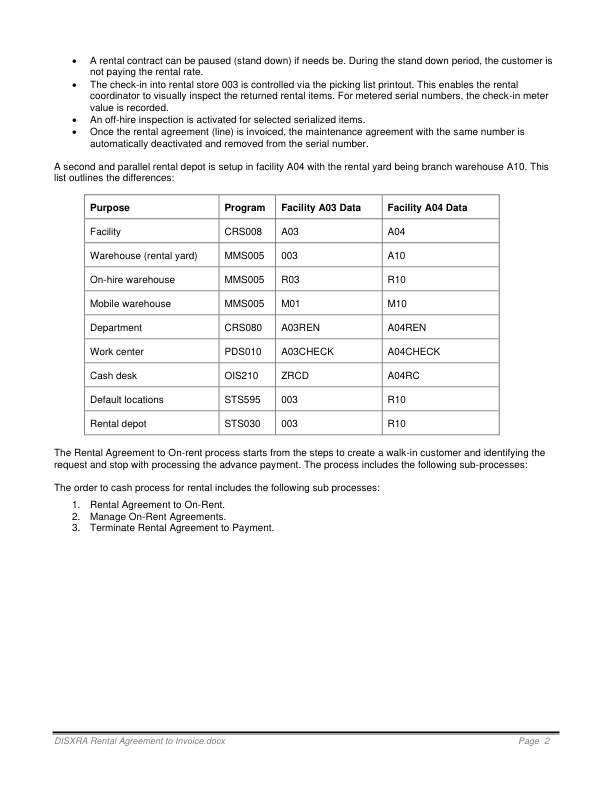

Page 2 analysis:
The content of the second page of the "DISXRA Rental Agreement to Invoice" document outlines key processes and operational details related to rental agreements. Here are the main points broken down:

### Overview of Key Points:

1. **Rental Contract Management**:
   - **Pause Option**: Contracts can be paused during which the customer does not incur rental fees.
   
2. **Check-in Process**:
   - **Controlled via Picking List**: The check-in of rental items at store 003 requires a picking list for visual inspection, particularly for metered serial numbers where meter values are recorded.

3. **Off-Hire Inspection**:
   - Selected serialized items undergo an off-hire inspection to check their condition upon return.

4. **Invoicing and Maintenance Agreement**:
   - Upon invoicing a rental agreement, associated maintenance agreements are automatically deactivated and disassociated from the serial number.

5. **Rental Depots**:
   - A comparison table between two facilities

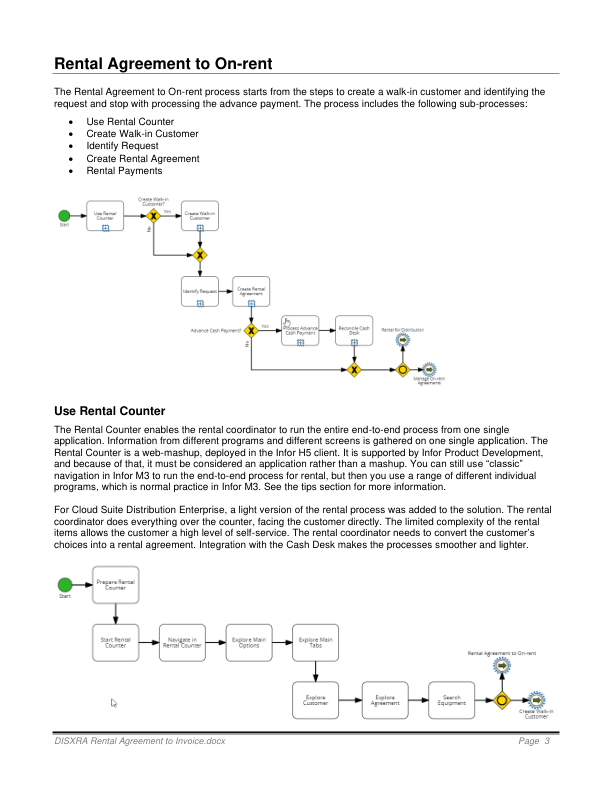

Page 3 analysis:
The content of the "DISXRA Rental Agreement to Invoice.docx" on page 3 outlines the process for creating a rental agreement for on-rent services, specifically detailing the steps and functionalities involved. Here’s a summary of the main points:

### Overview of the Rental Process
- The process starts with creating a walk-in customer and identifying their requests, culminating in processing an advance payment.
- Key sub-processes outlined include:
  - **Use Rental Counter**
  - **Create Walk-in Customer**
  - **Identify Request**
  - **Create Rental Agreement**
  - **Rental Payments**

### Use Rental Counter
- **Functionality**: The Rental Counter allows rental coordinators to manage the entire rental process through a single application.
- **Integration**: It consolidates information from various programs and screens, simplifying workflow.
- **Web Mashup**: Deployed via the Infor H5 client and supported by Infor Product Development.
- **Alternative Methods**: While a 

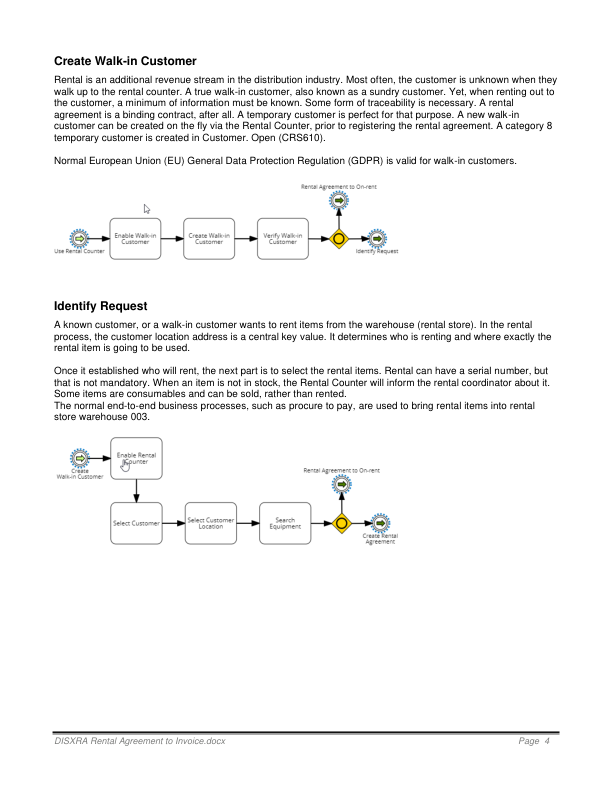

Page 4 analysis:
The content of the document outlines procedures and considerations for handling walk-in customers at a rental counter, particularly in the context of a rental agreement. Here’s a summary of the key points:

### Create Walk-in Customer
- **Definition**: A walk-in customer is typically unknown to the rental counter and may be referred to as a sundry customer.
- **Requirements**: Basic information is necessary for creating a rental agreement, which is a legally binding contract.
- **Temporary Customer Creation**: A walk-in customer can be established on-the-spot using the Rental Counter system, creating a category 8 temporary customer in the database.
- **Regulations**: The EU General Data Protection Regulation (GDPR) applies to these customers, emphasizing the importance of data protection.

### Identify Request
- **Rental Process**: The customer's location is crucial as it determines who is renting and where the rental item will be utilized.
- **Selecting Rental Items**

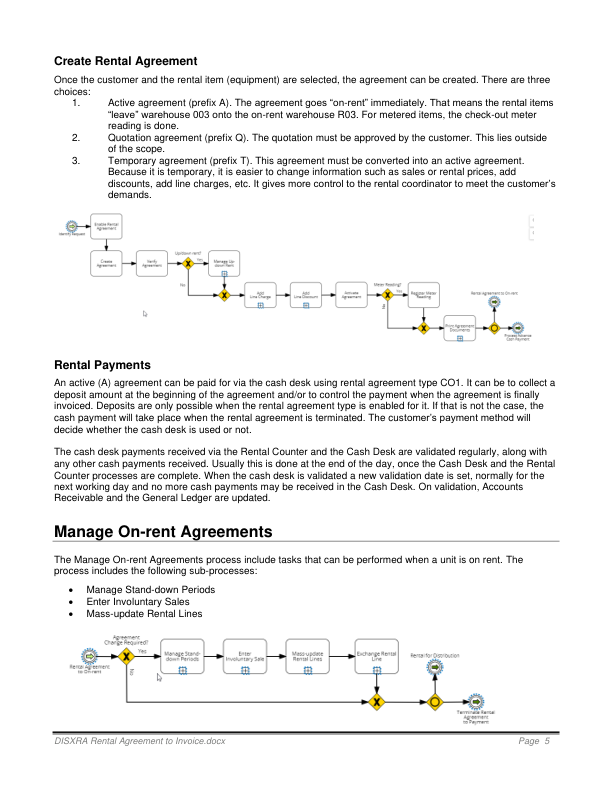

Page 5 analysis:
The content of page 5 from the "DISXRA Rental Agreement to Invoice.docx" outlines the procedures related to creating rental agreements and managing payments. Here’s a structured analysis:

### Create Rental Agreement
Three types of rental agreements are defined:

1. **Active Agreement (prefix A)**: 
   - Initiates immediate rental.
   - Equipment moves from warehouse 003 to the on-rent warehouse R03.
   - Meter readings are recorded for metered items.

2. **Quotation Agreement (prefix Q)**: 
   - Requires customer approval before proceeding.
   - This type is not detailed in the subsequent processes.

3. **Temporary Agreement (prefix T)**: 
   - Must be converted to an active agreement later.
   - Allows for easier modifications (sales prices, discounts, etc.).
   - Offers better control for the rental coordinator.

### Rental Payments
- **Payment Methods**: Active agreements can be settled via the cash desk using rental agreement type CO1.
   - May involve a deposit a

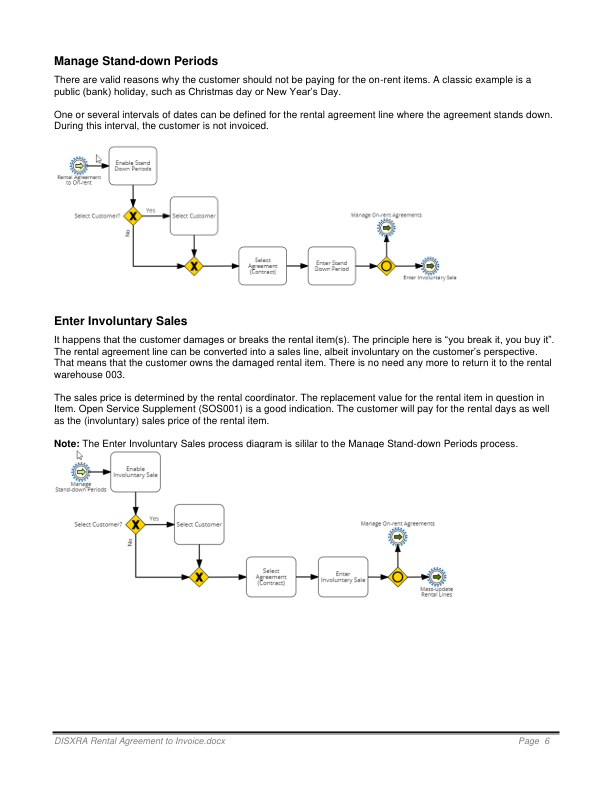

Page 6 analysis:
The content from page 6 of the "DISXRA Rental Agreement to Invoice" document outlines two main processes related to rental agreements: **Managing Stand-down Periods** and **Entering Involuntary Sales**.

### Manage Stand-down Periods
- **Purpose**: To specify times when customers should not be charged for on-rent items, such as during public holidays (e.g., Christmas, New Year's Day).
- **Process**: 
  - Time intervals can be defined within the rental agreement during which no charges are incurred.
  
### Enter Involuntary Sales
- **Purpose**: To address situations where a customer damages rental items.
- **Principle**: The concept of "you break it, you buy it" applies, meaning that if a rental item is damaged, the customer must purchase it rather than returning it.
- **Process**: 
  - The rental agreement line may be converted into a sale.
  - The rental coordinator determines the sales price based on the item's replacement value.
  - The customer will be charged for 

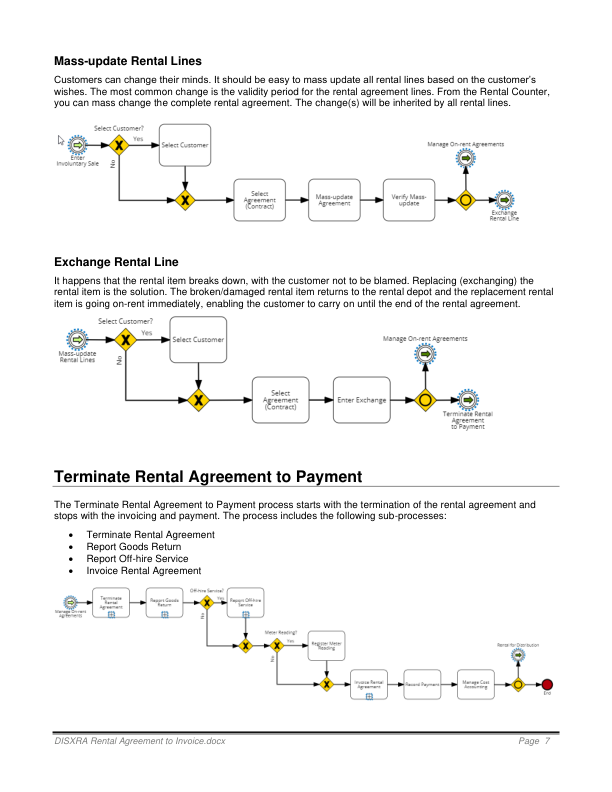

Page 7 analysis:
The content of the document appears to describe processes related to rental agreements, specifically focused on updating and managing rental lines, handling exchanges of rental items, and the termination of rental agreements leading up to invoicing and payment. Here’s a breakdown of the key sections:

### 1. **Mass-update Rental Lines**
   - **Purpose**: Allows for bulk changes to rental lines based on customer requests, primarily for adjusting the validity period of rental agreements.
   - **Process**: Initiated from the Rental Counter, changes made to the overall rental agreement will apply to all related rental lines.

### 2. **Exchange Rental Line**
   - **Scenario**: Addresses situations where a rental item may break down without any fault of the customer.
   - **Solution**: The damaged item is returned to the rental depot, and a replacement item is provided promptly to ensure continuity for the customer.

### 3. **Terminate Rental Agreement to Payment**
   - **Ov

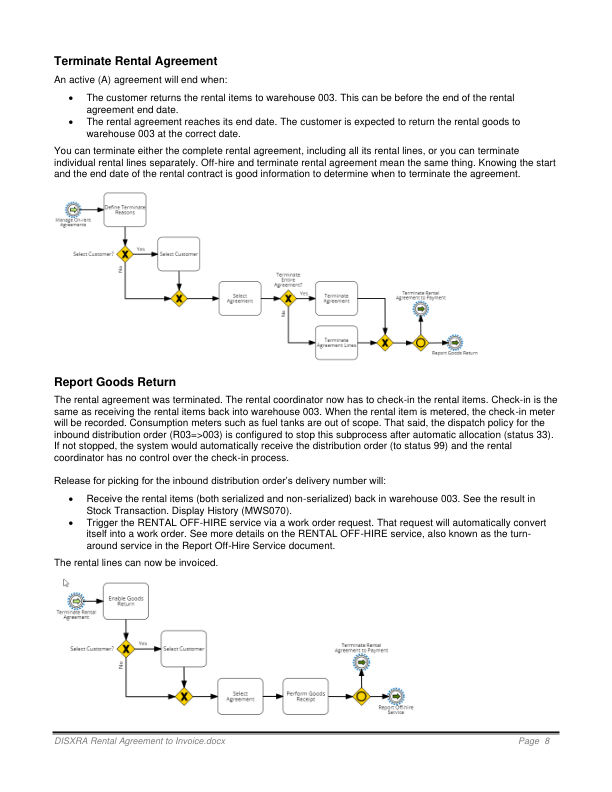

Page 8 analysis:
The content on page 8 of the "DISXRA Rental Agreement to Invoice" document provides a structured overview of the processes involved in terminating a rental agreement and reporting the return of rental goods.

### Key Sections:

#### 1. **Terminate Rental Agreement**
- **Conditions for Termination**:
  - The rental items are returned to warehouse 003 before the rental agreement's end date.
  - The rental agreement reaches its specified end date.

- **Options for Termination**:
  - The entire rental agreement can be terminated.
  - Individual rental lines can be terminated separately.

- **Terminology**:
  - "Off-hire" and "terminate rental agreement" are used interchangeably.

- **Importance of Dates**: Knowledge of the start and end dates of the rental contract is emphasized for effective termination management.

#### 2. **Report Goods Return**
- **Process After Termination**:
  - A rental coordinator must check in the returned items upon termination, which is akin to 

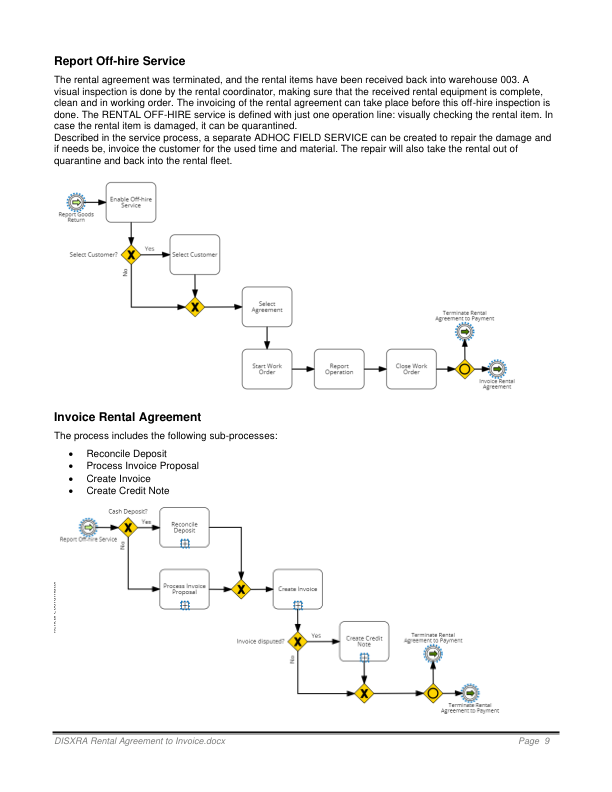

Page 9 analysis:
The content of page 9 of the "DISXRA Rental Agreement to Invoice.docx" outlines two main processes related to the rental of equipment: the **Report Off-hire Service** and the **Invoice Rental Agreement**.

### Report Off-hire Service

1. **Termination and Receipt**: 
   - The rental agreement is terminated, and the equipment is returned to warehouse 003.
   - A visual inspection by the rental coordinator ensures the equipment is complete, clean, and in working order.

2. **Invoicing Timing**: 
   - Invoicing can occur before the off-hire inspection.

3. **Rental Off-hire Service**:
   - Defined by one operation: visual inspection of the rental item.
   - If equipment is damaged, it can be quarantined.

4. **Adhoc Field Service**:
   - A separate service can be created to repair damages, which may involve additional invoicing for time and materials.
   - Repairs will also return the equipment back to the rental fleet.

### Invoice Rental Agreement

This section includes

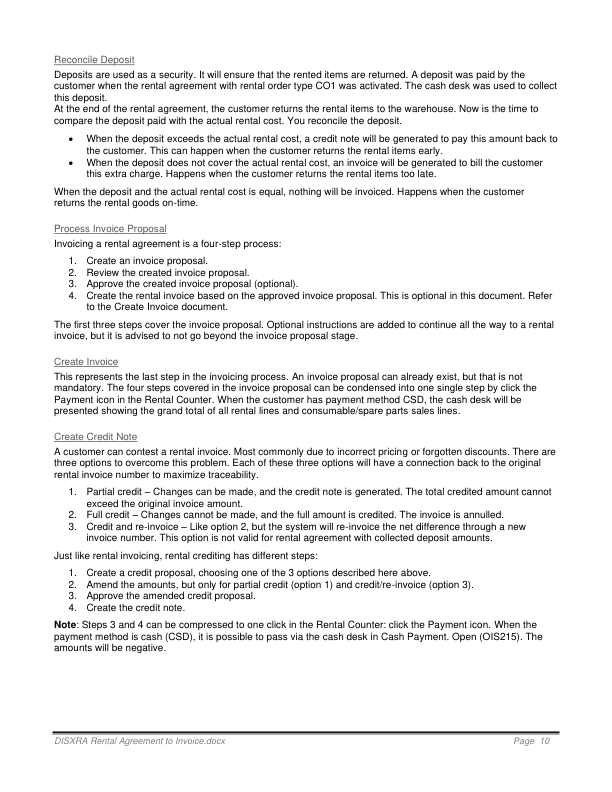

Page 10 analysis:
The content of the provided document page outlines the processes related to rental agreements, particularly focusing on deposit reconciliation, invoice proposals, credit notes, and invoicing procedures.

### Key Sections and Processes:

1. **Reconcile Deposit**:
   - Deposits serve as security for the rented items.
   - They are compared to the actual rental costs once items are returned.
   - Potential outcomes post-reconciliation include:
     - **Exceeding Deposit**: If the deposit exceeds the rental cost, a credit note is issued.
     - **Insufficient Deposit**: If it does not cover the rental cost, an invoice is created for the extra charge.
     - **Equal Deposit**: No additional actions are taken when they match.

2. **Process Invoice Proposal**:
   - Invoicing involves a four-step process:
     1. Create an invoice proposal.
     2. Review the proposal.
     3. Approve the proposal (optional).
     4. Create the rental invoice based on the proposal (optional).

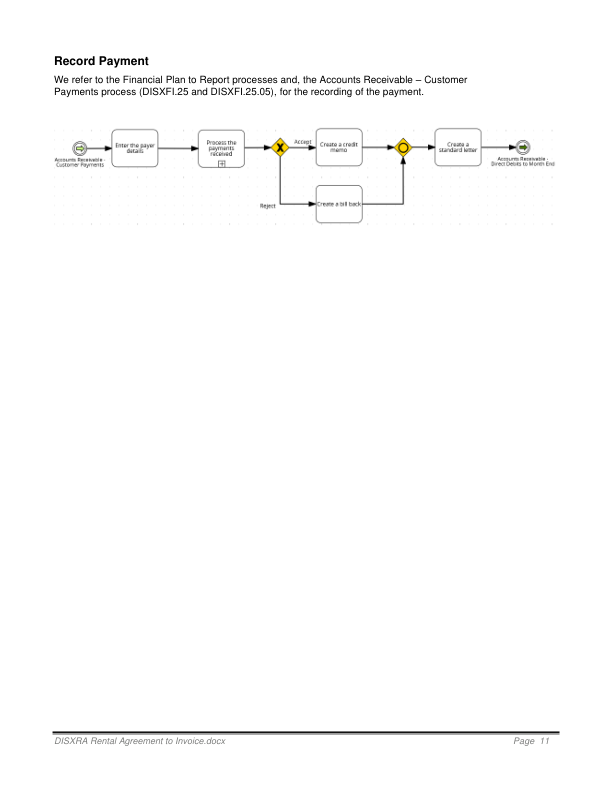

Page 11 analysis:
The content from page 11 of the "DISXRA Rental Agreement to Invoice.docx" outlines the process for recording customer payments within a financial context. Here's a summary of the key elements:

1. **Title**: "Record Payment" indicates the focus of this section is on the procedures for documenting payments made by customers.

2. **Reference Documents**: It mentions referencing the "Financial Plan to Report processes" and the "Accounts Receivable – Customer Payments process" (identified as DISXFI.25 and DISXFI.25.05). This suggests that there are established guidelines or protocols for managing and recording customer payments.

3. **Flowchart**: The accompanying flowchart illustrates the steps involved in the payment recording process:
   - **Enter the payment details**: This is the initial step where payment information is inputted.
   - **Process the payment received**: This indicates a verification or processing phase.
   - **Decision Point**: An acceptance or reject

In [6]:
import base64
import io
import fitz
from PIL import Image
from IPython.display import Image as IPImage, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def get_pdf_content(pdf_path: str) -> dict:
    pdf_document = fitz.open(pdf_path)
    text = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text.append(page.get_text())
    return text

# Get the content of the PDF file
pdf_text = get_pdf_content("../../data/test_with_images.pdf")

# Path to the PDF file
pdf_path = "../../data/test_with_images.pdf"

# Initialize the multimodal model
llm = ChatOpenAI(model="gpt-4o-mini")

# Iterate over each page and analyze content
for page_num, page_text in enumerate(pdf_text, start=1):
    # Convert the page to a base64 image
    base64_image = pdf_page_to_base64(pdf_path, page_num)
    display(IPImage(data=base64.b64decode(base64_image)))

    # Define the query
    query = f"Analyze the content of page {page_num}"

    # Create the message with text and image
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {"type": "text", "text": page_text},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )
    # Query the model
    response = llm.invoke([message])
    print(f"Page {page_num} analysis:\n{response.content}\n")